<h1 class='font-effect-3d' style='font-family:Ewert; color:#ff355e;'>📑 Styling, Links and Modules</h1>

---

#### [🌐 tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras)
#### [🌐 The Data Set of Flower Images (R)](https://www.kaggle.com/olgabelitskaya/the-data-set-of-flower-images-r) & [🌐 Github Repository](https://github.com/OlgaBelitskaya/deep_learning_projects/tree/master/DL_PP0) & [🌐 Google Colaboratory Version](https://colab.research.google.com/drive/1H2ArWH_1kYfkIoCbxleX-aHAozRVBAdB)

In [1]:
%%html
<style> 
@import url('https://fonts.googleapis.com/css?family=Ewert|Roboto&effect=3d'); 
a,h4 {color:slategray; font-family:Roboto; text-shadow:3px 3px 3px #aaa;}
span {color:black; font-family:Roboto; text-shadow:3px 3px 3px #aaa;}
div.output_prompt,div.output_area pre {color:slategray;}
div.input_prompt,div.output_subarea {color:#ff355e;}      
div.output_stderr pre {background-color:gainsboro;}  
div.output_stderr {background-color:slategrey;}     
</style>

In [2]:
import warnings; warnings.filterwarnings('ignore')
import pandas as pd,numpy as np,pylab as pl
import h5py,cv2,os,tensorflow as tf
import tensorflow.keras.preprocessing.image as tkimg
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import \
MaxPooling2D,Conv2D,Dense,LSTM,PReLU,LeakyReLU,\
BatchNormalization,Flatten,Activation,Dropout,\
GlobalMaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.callbacks import \
ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image \
import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 \
import InceptionV3
from keras.applications.vgg16 import VGG16
files_path='../input/flower-color-images/'
fw='/checkpoints'
print('tensorflow version:',tf.__version__)

tensorflow version: 2.1.0


Using TensorFlow backend.


In [3]:
def keras_history_plot(fit_history,fig_size,color='#ff355e'):
    keys=list(fit_history.history.keys())
    list_history=[fit_history.history[keys[i]] 
                  for i in range(len(keys))]
    dfkeys=pd.DataFrame(list_history).T
    dfkeys.columns=keys
    fig=pl.figure(figsize=(fig_size,fig_size))
    ax1=fig.add_subplot(2,1,1)
    dfkeys.iloc[:,[0,2]].plot(
        ax=ax1,color=['slategray',color],grid=True)
    ax2=fig.add_subplot(2,1,2)
    dfkeys.iloc[:,[1,3]].plot(
        ax=ax2,color=['slategray',color],grid=True)
    pl.tight_layout(); pl.show()
def cb(fw):
    early_stopping=EarlyStopping(
        monitor='val_loss',patience=20,verbose=2)
    checkpointer=ModelCheckpoint(
        filepath=fw,save_best_only=True,verbose=2,
        save_weights_only=True,monitor='val_accuracy',mode='max')
    lr_reduction=ReduceLROnPlateau(
        monitor='val_loss',verbose=2,patience=5,factor=.8)
    return [checkpointer,early_stopping,lr_reduction]

In [4]:
#tpu=tf.distribute.cluster_resolver.TPUClusterResolver()
#tf.config.experimental_connect_to_cluster(tpu)
#tf.tpu.experimental.initialize_tpu_system(tpu)
#tpu_strategy=tf.distribute.experimental.TPUStrategy(tpu)
#with tpu_strategy.scope():

<h1 class='font-effect-3d' style='font-family:Ewert; color:#ff355e'>📑 Data Exploration</h1>

Images` Array: (210, 128, 128, 3)
Labels` Array: (210,)


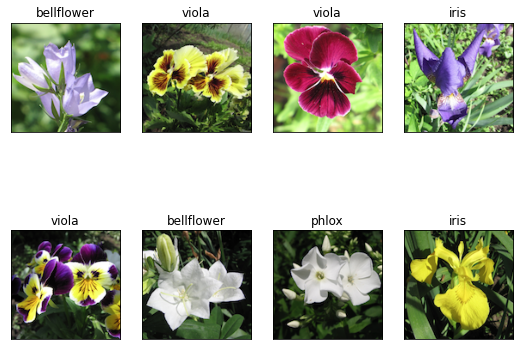

In [5]:
with h5py.File(files_path+\
               'FlowerColorImages.h5','r') as f:
    keys=list(f.keys())
    images=np.array(f[keys[0]],dtype='float32')/255
    labels=np.array(f[keys[1]],dtype='int32')
    f.close()
names=['phlox','rose','calendula','iris',
       'max chrysanthemum','bellflower','viola',
       'rudbeckia laciniata','peony','aquilegia']
fig=pl.figure(figsize=(9,7))
n=np.random.randint(1,30)
for i in range(n,n+8):
    ax=fig.add_subplot(2,4,i-n+1,\
    xticks=[],yticks=[],title=names[labels[i]])
    ax.imshow((images[i]))
st1='Images` Array: %s'
st2='Labels` Array: %s'
print(st1%str(images.shape))
print(st2%str(labels.shape))

In [6]:
x_train,x_test,y_train,y_test=\
train_test_split(images,labels,test_size=.1,random_state=1)
m=int(len(x_test)/2)
x_valid,y_valid=x_test[:m],y_test[:m]
x_test,y_test=x_test[m:],y_test[m:]
print([x_train.shape,x_test.shape,x_valid.shape,
       y_train.shape,y_test.shape,y_valid.shape])

[(189, 128, 128, 3), (11, 128, 128, 3), (10, 128, 128, 3), (189,), (11,), (10,)]


<h1 class='font-effect-3d' style='font-family:Ewert; color:#ff355e'>📑 Keras Applications</h1>

#### InceptionV3

In [7]:
steps,epochs=12,10
iv3_model,fr_history,unfr_history=[],[],[]
def inceptionv3_train():
    global steps,epochs,iv3_model,fr_history,unfr_history
    iv3base_model=InceptionV3(
        weights='imagenet',include_top=False)
    x=iv3base_model.output
    x=GlobalAveragePooling2D()(x)
    x=Dense(512,activation='relu')(x)
    y=Dense(10,activation='softmax')(x)
    iv3_model=Model(inputs=iv3base_model.input,outputs=y)
    # freezing convolutional layers
    for layer in iv3base_model.layers:
        layer.trainable=False
    iv3_model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='nadam',metrics=['accuracy'])
    early_stopping=EarlyStopping(
        monitor='val_loss',patience=20,verbose=2)
    checkpointer=ModelCheckpoint(
        filepath=fw,save_best_only=True,verbose=2,
        save_weights_only=True,monitor='val_accuracy',mode='max')
    lr_reduction=ReduceLROnPlateau(
        monitor='val_loss',verbose=2,patience=5,factor=.8)
    data_generator=ImageDataGenerator(
        shear_range=.2,zoom_range=.2,horizontal_flip=True)
    fr_history=iv3_model.fit_generator(data_generator.flow(
        x_train,y_train,batch_size=16),
        steps_per_epoch=steps,epochs=epochs,verbose=2, 
        validation_data=(x_valid,y_valid),
        callbacks=[checkpointer,early_stopping,lr_reduction])
    #for layer in iv3_model.layers[:173]:
    #    layer.trainable=False
    # unfreezing the layers [173:]
    for layer in iv3_model.layers:
         layer.trainable=True   
    iv3_model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='nadam',metrics=['accuracy'])
    unfr_history=iv3_model.fit_generator(data_generator.flow(
        x_train,y_train,batch_size=16),verbose=2,
        steps_per_epoch=steps,epochs=epochs,
        callbacks=[checkpointer,early_stopping,lr_reduction],
        validation_data=(x_valid,y_valid))

In [8]:
inceptionv3_train()

87916544/87910968 [==============================] - 1s 0us/step
Train for 12 steps, validate on 10 samples
Epoch 1/10

Epoch 00001: val_accuracy improved from -inf to 0.40000, saving model to /checkpoints
12/12 - 11s - loss: 2.5812 - accuracy: 0.1481 - val_loss: 2.8564 - val_accuracy: 0.4000
Epoch 2/10

Epoch 00002: val_accuracy improved from 0.40000 to 0.50000, saving model to /checkpoints
12/12 - 1s - loss: 1.8168 - accuracy: 0.3915 - val_loss: 4.0680 - val_accuracy: 0.5000
Epoch 3/10

Epoch 00003: val_accuracy did not improve from 0.50000
12/12 - 1s - loss: 1.4253 - accuracy: 0.5767 - val_loss: 4.7141 - val_accuracy: 0.3000
Epoch 4/10

Epoch 00004: val_accuracy did not improve from 0.50000
12/12 - 1s - loss: 1.1766 - accuracy: 0.6138 - val_loss: 5.3919 - val_accuracy: 0.5000
Epoch 5/10

Epoch 00005: val_accuracy did not improve from 0.50000
12/12 - 1s - loss: 1.0306 - accuracy: 0.6984 - val_loss: 6.3043 - val_accuracy: 0.3000
Epoch 6/10

Epoch 00006: val_accuracy did not improve fr

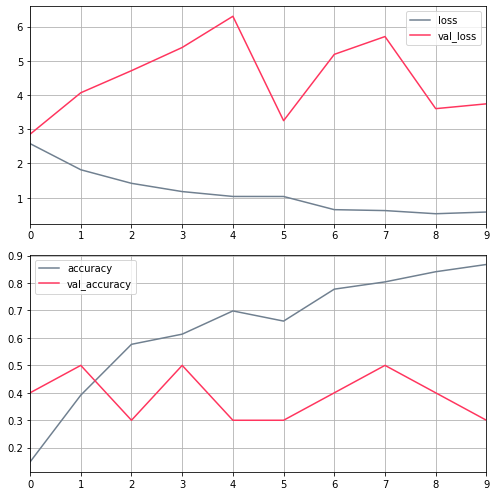

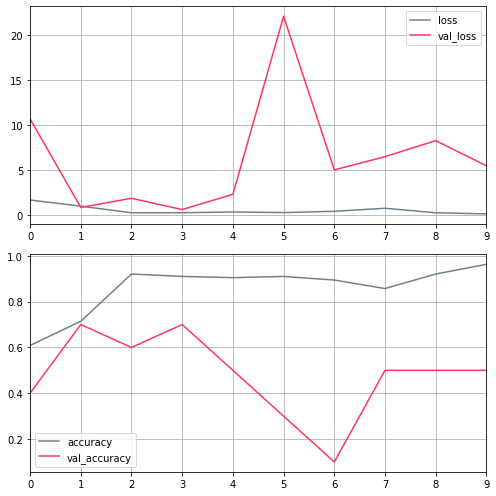

[3.707000970840454, 0.27272728]

In [9]:
keras_history_plot(fr_history,7)
keras_history_plot(unfr_history,7)
iv3_model.load_weights(fw)
iv3_model.evaluate(x_test,y_test,verbose=0)

In [10]:
for i,layer in enumerate(iv3_model.layers):
    print(i,layer.name)

0 input_1
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_12
52 conv2d_14
53 conv2d_17
54 conv2d_18
55 batch_normalization_12
56 batch_normalization_14
5

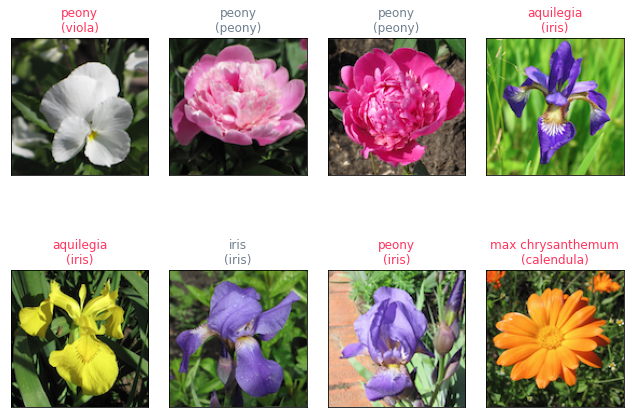

In [11]:
y_test_predict=np.argmax(iv3_model.predict(x_test),axis=1)
fig=pl.figure(figsize=(9,7))
randch=np.random.choice(x_test.shape[0],size=8,replace=False)
for i,idx in enumerate(randch):
    ax=fig.add_subplot(2,4,i+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx=y_test_predict[idx]
    true_idx=y_test[idx]
    ti='{}\n({})'.format(names[pred_idx],names[true_idx])
    ax.set_title(ti,color=(
        'slategray' if pred_idx==true_idx else '#ff355e'))
pl.tight_layout(); pl.show()

#### VGG16

In [12]:
vgg16base_model=VGG16(weights='imagenet',
                      include_top=False)
pvx_train=vgg16base_model.predict(x_train)
pvx_valid=vgg16base_model.predict(x_valid)
pvx_test=vgg16base_model.predict(x_test)
sh=pvx_train.shape[1:]

58892288/58889256 [==============================] - 1s 0us/step


In [13]:
def vgg16model():
    model=Sequential()  
    model.add(GlobalAveragePooling2D(input_shape=sh))   
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.5))        
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.25))   
    model.add(Dense(10,activation='softmax'))    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='nadam',metrics=['accuracy'])
    return model
vgg16model=vgg16model()

In [14]:
early_stopping=EarlyStopping(
    monitor='val_loss',patience=20,verbose=2)
checkpointer=ModelCheckpoint(
    filepath=fw,save_best_only=True,verbose=2,
    save_weights_only=True,monitor='val_accuracy',mode='max')
lr_reduction=ReduceLROnPlateau(
    monitor='val_loss',verbose=2,patience=5,factor=.8)
history=vgg16model.fit(
    pvx_train,y_train,validation_data=(pvx_valid,y_valid), 
    epochs=100,batch_size=64,verbose=2, 
    callbacks=[checkpointer,lr_reduction,early_stopping])

Train on 189 samples, validate on 10 samples
Epoch 1/100

Epoch 00001: val_accuracy improved from -inf to 0.10000, saving model to /checkpoints
189/189 - 1s - loss: 2.4457 - accuracy: 0.0635 - val_loss: 2.3306 - val_accuracy: 0.1000
Epoch 2/100

Epoch 00002: val_accuracy did not improve from 0.10000
189/189 - 0s - loss: 2.2992 - accuracy: 0.1164 - val_loss: 2.2127 - val_accuracy: 0.1000
Epoch 3/100

Epoch 00003: val_accuracy improved from 0.10000 to 0.50000, saving model to /checkpoints
189/189 - 0s - loss: 2.2579 - accuracy: 0.1587 - val_loss: 2.1622 - val_accuracy: 0.5000
Epoch 4/100

Epoch 00004: val_accuracy did not improve from 0.50000
189/189 - 0s - loss: 2.2513 - accuracy: 0.1164 - val_loss: 2.1265 - val_accuracy: 0.5000
Epoch 5/100

Epoch 00005: val_accuracy did not improve from 0.50000
189/189 - 0s - loss: 2.1437 - accuracy: 0.2011 - val_loss: 1.9659 - val_accuracy: 0.5000
Epoch 6/100

Epoch 00006: val_accuracy improved from 0.50000 to 0.60000, saving model to /checkpoints
189

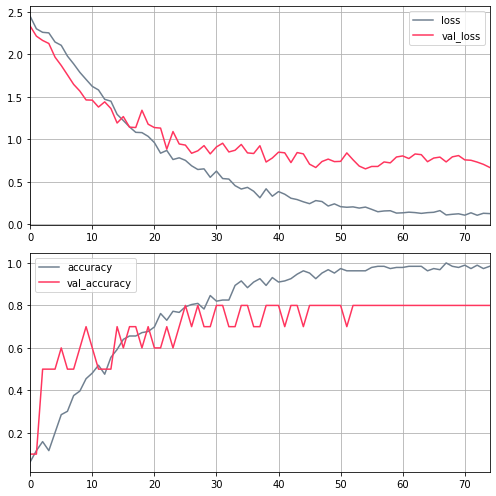

[0.9045694470405579, 0.8181818]

In [15]:
keras_history_plot(history,7)
vgg16model.load_weights(fw)
vgg16model.evaluate(pvx_test,y_test,verbose=0)

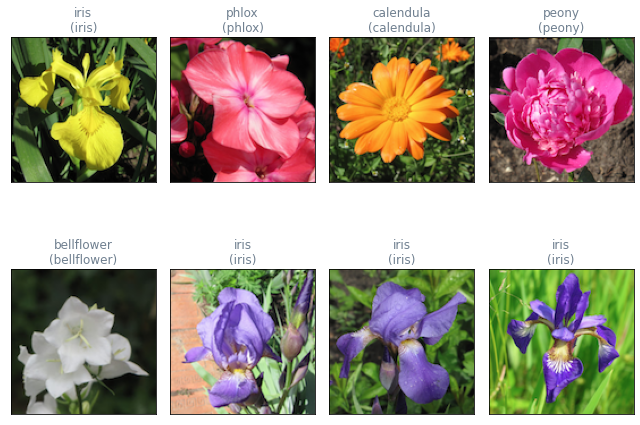

In [16]:
y_test_predict=np.argmax(vgg16model.predict(pvx_test),axis=1)
fig=pl.figure(figsize=(9,7))
randch=np.random.choice(x_test.shape[0],size=8,replace=False)
for i,idx in enumerate(randch):
    ax=fig.add_subplot(2,4,i+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx=y_test_predict[idx]
    true_idx=y_test[idx]
    ti='{}\n({})'.format(names[pred_idx],names[true_idx])
    ax.set_title(ti,color=(
        'slategray' if pred_idx==true_idx else '#ff355e'))
pl.tight_layout(); pl.show()